In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

In [2]:
def log_scraper(filename: str) -> Dict:
    print(filename)
    "parses a log file and returns a dictionary of time statistics"
    stats = {i: [] for i in range(5)}
    with open(filename) as f:
        lines = f.readlines()

    run = 0
    for j,line in enumerate(lines):
        if "Run" in line:
            run += 1
            continue
        tokens = line.split(" ")
        timestamp = tokens[1]
        stats[run].append(timestamp)

    return stats

In [3]:
def timestamp_diff(timestamps: List) -> np.ndarray:
    """returns np array of time differences in seconds between epochs stamped in H:M:S.MS format.
    Assumes all jobs take less than a day of total compute time
    """
    diffs = []
    i_0, i_1 = 0, 1
    for _ in range(len(timestamps) - 1):
        t_i, t_f = timestamps[i_0], timestamps[i_1]
        t_i = t_i.split(":")
        t_f = t_f.split(":")
        h_i, m_i, s_i = float(t_i[0]), float(t_i[1]), float(t_i[2])
        h_f, m_f, s_f = float(t_f[0]), float(t_f[1]), float(t_f[2])
        initial = (h_i*3600.0) + (m_i*60.0) + (s_i)
        final = (h_f*3600.0) + (m_f*60.0) + (s_f)

        if final < initial:
            final =+ 86400 # adjust for mod 24 hour day
        diffs.append(final-initial)
        i_0 +=1
        i_1 +=1
    return np.array(diffs)

In [4]:
def get_stats(fn_template: str, setups: Tuple[int,int], runs, root: str="pvc_reddit") -> Tuple[np.ndarray, np.ndarray]:
    """This takes an average of 3 independent jobs - it only makes sense if all jobs have the same number of epochs"""
    epoch_avgs = []
    epoch_vars = []
    for setup in setups:
        all_run_diffs = []
        for run in runs:
            stats = log_scraper(root + f"run_{run}/" + fn_template.format(setup[0], setup[1]))
            all_run_diffs.append(np.array([timestamp_diff(stats[i]) for i in range(1,5)]).flatten())
        all_run_diffs = np.array(all_run_diffs).flatten()
        epoch_avg = np.average(all_run_diffs)
        epoch_var = np.var(all_run_diffs)
        epoch_avgs.append(epoch_avg)
        epoch_vars.append(epoch_var)
    return np.array(epoch_avgs), np.array(epoch_vars)

In [5]:
a100_setups = [(1,1),(1,2),(1,4),(2,8),(4,16),(6,24)]
com_setups = [(1,2),(1,4),(1,8),(2,16),(4,32),(6,48)]

com_temp = "reddit_pyg_gpu-pvc_nodes_{0}_gpus_{1}_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log"
com_epoch_avgs, com_epoch_vars = get_stats(com_temp, com_setups, runs=[4], root="pvc_reddit/")

opt_com_temp = "reddit_pyg_gpu-pvc_nodes_{0}_gpus_{1}_batchsize_1024_epochs_25_optimize_True_dtype_f32_hierarchy_COMPOSITE.log"
opt_com_epoch_avgs, opt_com_epoch_vars = get_stats(opt_com_temp, com_setups, runs=[4], root="pvc_reddit/")

a100_temp = "reddit_pyg_gpu-a100_nodes_{0}_gpus_{1}_batchsize_2048_epochs_25_optimize_False_dtype_f32.log"
a100_epoch_avgs, a100_epoch_vars = get_stats(a100_temp, a100_setups, runs=[4], root="a100_reddit/")


pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_1_gpus_2_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_1_gpus_4_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_1_gpus_8_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_2_gpus_16_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_4_gpus_32_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_6_gpus_48_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_1_gpus_2_batchsize_1024_epochs_25_optimize_True_dtype_f32_hierarchy_COMPOSITE.log
pvc_reddit/run_4/reddit_pyg_gpu-pvc_nodes_1_gpus_4_batchsize_1024_epochs_25_optimize_True_dtype_f32_hierarchy_COMPOSITE.log

In [6]:
gpu_array = np.array([1,2,4,8,16,28])
sage_training_data = np.stack([gpu_array.T, a100_epoch_avgs.T, com_epoch_avgs.T, opt_com_epoch_avgs.T])
print(sage_training_data.T)
np.savetxt("sage_train_f32.csv", sage_training_data.T, delimiter="   ",fmt='%1.3f')

[[ 1.         12.18096875 41.94194792 41.79528125]
 [ 2.          6.42723958 21.77394792 21.98163542]
 [ 4.          3.66708333 11.69488542 11.65773958]
 [ 8.          2.08298958  6.14685417  6.18434375]
 [16.          1.27579167  3.35369792  3.35741667]
 [28.          0.91591667  1.95391667  1.95504167]]


In [7]:
resnet_training_data = np.stack([gpu_array.T,
                                 a100_epoch_avgs[0]/a100_epoch_avgs.T,
                                 com_epoch_avgs[0]/com_epoch_avgs.T,
                                 opt_com_epoch_avgs[0]/opt_com_epoch_avgs.T])
print(resnet_training_data.T)
np.savetxt("sage_speedup_f32.csv", resnet_training_data.T, delimiter="   ",fmt='%1.3f')

[[ 1.          1.          1.          1.        ]
 [ 2.          1.89521     1.92624452  1.90137269]
 [ 4.          3.32170492  3.58634962  3.58519599]
 [ 8.          5.84782989  6.82331918  6.75824031]
 [16.          9.54777262 12.50617944 12.44864293]
 [28.         13.29921072 21.46557662 21.37820485]]


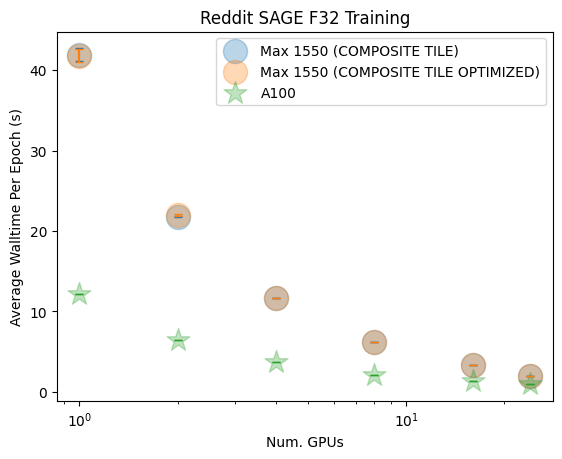

In [8]:
n_gpus = [i[-1] for i in a100_setups]

plt.errorbar(n_gpus, com_epoch_avgs, yerr=com_epoch_vars,linestyle="None", capsize=3)
plt.scatter(n_gpus, com_epoch_avgs, s=300, label="Max 1550 (COMPOSITE TILE)", alpha=0.3)

plt.errorbar(n_gpus, opt_com_epoch_avgs, yerr=opt_com_epoch_vars,linestyle="None", capsize=3)
plt.scatter(n_gpus, opt_com_epoch_avgs, s=300, label="Max 1550 (COMPOSITE TILE OPTIMIZED)", alpha=0.3)

plt.errorbar(n_gpus, a100_epoch_avgs, yerr=a100_epoch_vars,linestyle="None", capsize=3)
plt.scatter(n_gpus, a100_epoch_avgs, s=300, label="A100", alpha=0.3, marker="*")

plt.xscale("log")
plt.title("Reddit SAGE F32 Training")
plt.ylabel("Average Walltime Per Epoch (s)")
plt.xlabel("Num. GPUs")
plt.legend(loc='best')
plt.show()


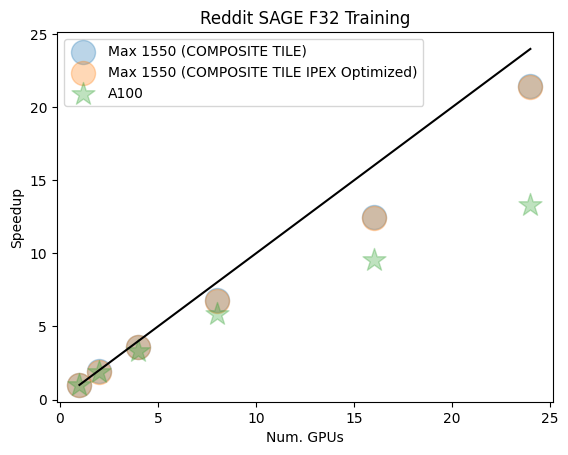

In [9]:

plt.scatter(n_gpus, com_epoch_avgs[0]/com_epoch_avgs, s=300, label="Max 1550 (COMPOSITE TILE)", alpha=0.3)

plt.scatter(n_gpus, opt_com_epoch_avgs[0]/opt_com_epoch_avgs, s=300, label="Max 1550 (COMPOSITE TILE IPEX Optimized)", alpha=0.3)

plt.scatter(n_gpus, a100_epoch_avgs[0]/a100_epoch_avgs, s=300, label="A100", marker="*", alpha=0.3)

plt.plot(n_gpus,n_gpus, color='black')
plt.title("Reddit SAGE F32 Training")
plt.ylabel("Speedup")
plt.xlabel("Num. GPUs")
plt.legend(loc='best')
plt.show()